# 1. Info

Notebook with all the code needed to solve the homework for the week number 9 of the machine learning zoomcamp.

## Instal the required libraries

In [21]:
import tensorflow as tf
from tensorflow import keras
import os
import tensorflow.lite as tflite
import numpy as np

## Geting the data

In this homework, we'll deploy the bees vs wasps model we trained in the previous homework.

Download the model from here:

https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5

# Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the converted model?

* 21 Mb
* 43 Mb
* 80 Mb
* 164 Mb

In [4]:
# read the model
model = keras.models.load_model('./bees-wasps.h5')

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('bees-wasps.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/mp/f2dl1s8d49715klyjxpxjksm0000gn/T/tmptln7qp19/assets


INFO:tensorflow:Assets written to: /var/folders/mp/f2dl1s8d49715klyjxpxjksm0000gn/T/tmptln7qp19/assets
2023-11-28 17:23:23.783069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-28 17:23:23.783083: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-28 17:23:23.784634: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/mp/f2dl1s8d49715klyjxpxjksm0000gn/T/tmptln7qp19
2023-11-28 17:23:23.785153: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-28 17:23:23.785157: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/mp/f2dl1s8d49715klyjxpxjksm0000gn/T/tmptln7qp19
2023-11-28 17:23:23.786846: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-11-28 17:23:23.787548: I tensorflow/cc/saved_model/load

In [8]:
!ls -lh bees-wasps.tflite

-rw-r--r--@ 1 sergiososabautista  staff    43M Nov 28 17:23 bees-wasps.tflite


# Question 2

To be able to use this model, we need to know the index of the input and the index of the output.

What's the output index for this model?

* 3
* 7
* 13
* 24

In [10]:
interpreter = tflite.Interpreter(model_path='./bees-wasps.tflite')
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
interpreter.get_output_details()[0]['index']

13

# Preparing the image

You'll need some code for downloading and resizing images. You can use this code:

In [12]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

For that, you'll need to have pillow installed:

```
    pip install pillow
```


Let's download and resize this image:

https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

Based on the previous homework, what should be the target size for the image?

Answer = (150,150)

In [15]:
url = 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'

In [17]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [20]:
image = download_image(url)
img = prepare_image(image, target_size=(150,150))

# Question 3

Now we need to turn the image into numpy array and pre-process it.

Tip: Check the previous homework. What was the pre-processing we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

* 0.3450980
* 0.5450980
* 0.7450980
* 0.9450980

In [29]:
x = np.array(img, dtype='float32')
X = np.array([x])

X = X/255.

In [31]:
X[0,0,0,0]

0.94509804

# Question 4

Now let's apply this model to this image. What's the output of the model?

* 0.258
* 0.458
* 0.658
* 0.858

In [32]:
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [33]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [37]:
preds[0,0]

0.65921456

# Prepare the lambda code

Now you need to copy all the code into a separate python file. You will need to use this file for the next two questions.

Tip: you can test this file locally with ipython or Jupyter Notebook by importing the file and invoking the function from this file.

# Docker

For the next two questions, we'll use a Docker image that we already prepared. This is the Dockerfile that we used for creating the image:

```
FROM public.ecr.aws/lambda/python:3.10
COPY bees-wasps-v2.tflite .
```

And pushed it to agrigorev/zoomcamp-bees-wasps:v2.

A few notes:

* The image already contains a model and it's not the same model as the one we used for questions 1-4.
* The version of Python is 3.10, so you need to use the right wheel for TF-Lite. For Tensorflow 2.14.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.14.0-cp310-cp310-linux_x86_64.whl

# Question 5

Download the base image agrigorev/zoomcamp-bees-wasps:v2. You can easily make it by using docker pull command.

So what's the size of this base image?

* 162 Mb
* 362 Mb
* 662 Mb
* 962 Mb

You can get this information when running docker images - it'll be in the "SIZE" column.

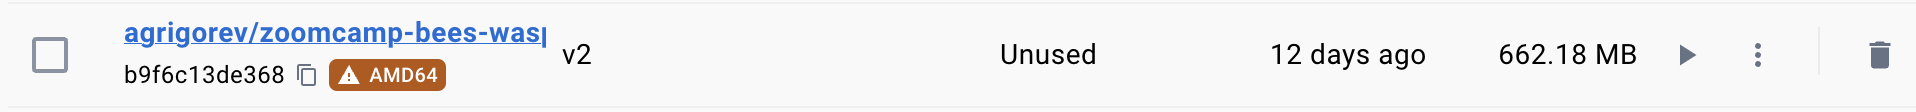